In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Change to your repo directory
%cd /content/drive/Shareddrives/CS231N/chestxray-classification

Mounted at /content/drive
/content/drive/Shareddrives/CS231N/chestxray-classification


In [3]:
# Load GitHub token from .env (optional, if needed later)
!pip install python-dotenv
import os
from dotenv import load_dotenv
load_dotenv(".env")

True

In [4]:
!git status


Refresh index: 100% (3/3), done.
On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	data/
	notebooks/

nothing added to commit but untracked files present (use "git add" to track)


In [1]:
# === Colab setup ===
from google.colab import drive
drive.mount('/content/drive')

# Change to your repo directory
%cd /content/drive/Shareddrives/CS231N/chestxray-classification

# Install dependencies
!pip install torchxrayvision python-dotenv scikit-learn --quiet

# Load GitHub token from .env (optional, if needed later)
import os
from dotenv import load_dotenv
load_dotenv(".env")

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = 'CS231n/assignments/assignment4/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/Shareddrives/{}'.format(FOLDERNAME))

# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import logging
import torch
import torchxrayvision as xrv
from torchvision import transforms
from PIL import Image
# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", force=True)

# Paths
data_path = "/content/drive/Shareddrives/CS231N/assignment4/cs231n/datasets/nih-chestxray"
image_path= "/content/drive/Shareddrives/CS231N/assignment4/cs231n/datasets/nih-chestxray/images"

Mounted at /content/drive
/content/drive/Shareddrives/CS231N/chestxray-classification
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torchxrayvision/utils.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# === Step 2: Load pretrained models ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load DenseNet121 pretrained on MIMIC-CXR
model_mimic = xrv.models.DenseNet(weights="densenet121-res224-mimic_ch").eval().to(device)

# Load DenseNet121 pretrained on CheXpert
model_chex = xrv.models.DenseNet(weights="densenet121-res224-chex").eval().to(device)

# Confirm label order is consistent between the two models
assert model_mimic.pathologies == model_chex.pathologies, "Label mismatch between models!"

# Print available labels
print("Model supports these labels:")
print(model_mimic.pathologies)

# Define target labels
target_labels = ["Cardiomegaly", "Atelectasis", "Effusion", "Pneumothorax"]
label_indices = [model_mimic.pathologies.index(lbl) for lbl in target_labels]


If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/mimic_ch-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/mimic_ch-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]
If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/chex-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]
Model supports these labels:
['Atelectasis', 'Consolidation', '', 'Pneumothorax', 'Edema', '', '', 'Effusion', 'Pneumonia', '', 'Cardiomegaly', '', '', '', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']


# DATA

In [5]:
# Filter metadata_df to match extracted images
csv_path = os.path.join(data_path, "Data_Entry_2017_v2020.csv")
metadata_df = pd.read_csv(csv_path)
e_path= "/content/drive/Shareddrives/CS231N/assignment4/cs231n/datasets/nih-chestxray/images"
available_images = {f for f in os.listdir(image_path) if f.endswith(".png")}
metadata_df = metadata_df[metadata_df["Image Index"].isin(available_images)]
print(f"Filtered to {len(metadata_df)} available images in local storage.")

Filtered to 54999 available images in local storage.


In [6]:
metadata_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


## Expand multi-labels into binary columns




In [7]:
# encode_labels: Ground truth multi-label vector aligned with model
# Encode the labels using model.pathologies order
def encode_labels(row, all_labels):
    findings = row["Finding Labels"].split("|")
    return [int(label in findings) for label in all_labels]

all_pathologies = model_mimic.pathologies

# Create a new column with 18-dim binary vector
metadata_df["encoded_labels"] = metadata_df.apply(lambda row: encode_labels(row, all_pathologies), axis=1)

## Define helper to check presence per disease

In [8]:
# Define helper to check presence per disease

# Convert encoded column to numpy array for slicing
metadata_df["encoded_array"] = metadata_df["encoded_labels"].apply(np.array)

# Helper function to check if a given disease is positive
def is_positive(label_index):
    return metadata_df["encoded_array"].apply(lambda x: x[label_index] == 1)

# Helper to check if all 4 target diseases are negative
def is_all_four_negative(row):
    return np.sum(row[label_indices]) == 0

metadata_df["is_all_four_negative"] = metadata_df["encoded_array"].apply(is_all_four_negative)

## Sample 400 positive examples per disease

In [9]:
# Sample 400 positive
positive_samples = []

for idx, label in zip(label_indices, target_labels):
    positives = metadata_df[is_positive(idx)]
    sampled = positives.sample(n=400, random_state=42)
    positive_samples.append(sampled)

# Combine all disease-positive samples
positive_df = pd.concat(positive_samples)

## Sample 400 negatives (zero for all 4 diseases)

In [10]:
# Sample 400 positive examples per disease
negative_df = metadata_df[metadata_df["is_all_four_negative"]].sample(n=400, random_state=42)

##  Combine, deduplicate, and save

In [11]:
test_df = pd.concat([positive_df, negative_df]).drop_duplicates(subset="Image Index").reset_index(drop=True)
print(f"Total test set size after deduplication: {len(test_df)}")

# Save the image list for reuse
test_df.to_csv("data/nih_test_set_balanced.csv", index=False)

Total test set size after deduplication: 1969


In [12]:
test_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],encoded_labels,encoded_array,is_all_four_negative
0,00011448_010.png,Cardiomegaly|Infiltration,10,11448,32,M,AP,2500,2048,0.168,0.168,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",False
1,00001232_002.png,Atelectasis|Cardiomegaly|Effusion|Infiltration,2,1232,60,F,AP,2500,2048,0.168,0.168,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...",False
2,00011702_072.png,Cardiomegaly|Infiltration,69,11702,25,F,AP,2500,2048,0.168,0.168,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",False
3,00000200_001.png,Cardiomegaly,1,200,76,M,PA,2992,2991,0.143,0.143,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",False
4,00001373_036.png,Atelectasis|Cardiomegaly|Consolidation|Effusion,38,1373,60,M,AP,3056,2544,0.139,0.139,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...",False


## Distribution Plot for Test Samples

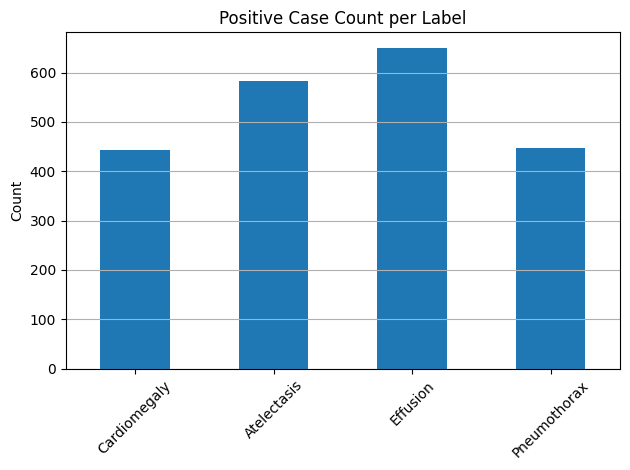

No Finding cases: 400 / 1969


In [13]:
# figure out distribution

import matplotlib.pyplot as plt

# Extract individual binary columns from encoded_array
for i, label in zip(label_indices, target_labels):
    test_df[label] = test_df["encoded_array"].apply(lambda x: x[i])

# Plot positive case count per disease
label_counts = test_df[target_labels].sum()
label_counts.plot(kind='bar')
plt.title("Positive Case Count per Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Count "No Finding" images — i.e., none of the 4 labels are present
num_no_findings = (test_df[target_labels].sum(axis=1) == 0).sum()
print(f"No Finding cases: {num_no_findings} / {len(test_df)}")

In [14]:
test_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],encoded_labels,encoded_array,is_all_four_negative,Cardiomegaly,Atelectasis,Effusion,Pneumothorax
0,00011448_010.png,Cardiomegaly|Infiltration,10,11448,32,M,AP,2500,2048,0.168,0.168,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",False,1,0,0,0
1,00001232_002.png,Atelectasis|Cardiomegaly|Effusion|Infiltration,2,1232,60,F,AP,2500,2048,0.168,0.168,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...",False,1,1,1,0
2,00011702_072.png,Cardiomegaly|Infiltration,69,11702,25,F,AP,2500,2048,0.168,0.168,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",False,1,0,0,0
3,00000200_001.png,Cardiomegaly,1,200,76,M,PA,2992,2991,0.143,0.143,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",False,1,0,0,0
4,00001373_036.png,Atelectasis|Cardiomegaly|Consolidation|Effusion,38,1373,60,M,AP,3056,2544,0.139,0.139,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...",False,1,1,1,0


In [21]:
import torchxrayvision as xrv
import skimage, torch, torchvision

# Prepare the image:
img = skimage.io.imread("/content/drive/Shareddrives/CS231N/assignment4/cs231n/datasets/nih-chestxray/images/00011448_010.png")
# img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
# img = img.mean(2)[None, ...] # Make single color channel

transform = torchvision.transforms.Compose([xrv.datasets.XRayResizer(224)])

img = transform(img)
img = torch.from_numpy(img)

# Load model and process image
model = xrv.models.DenseNet(weights="densenet121-res224-all")
outputs = model(img[None,...]) # or model.features(img[None,...])

# Print results
dict(zip(model.pathologies,outputs[0].detach().numpy()))



{'Atelectasis': np.float32(0.5939066),
 'Consolidation': np.float32(0.5751499),
 'Infiltration': np.float32(0.5314261),
 'Pneumothorax': np.float32(0.54722),
 'Edema': np.float32(0.5497111),
 'Emphysema': np.float32(0.523157),
 'Fibrosis': np.float32(0.5451323),
 'Effusion': np.float32(0.6785728),
 'Pneumonia': np.float32(0.5440699),
 'Pleural_Thickening': np.float32(0.5938924),
 'Cardiomegaly': np.float32(0.6066816),
 'Nodule': np.float32(0.52837235),
 'Mass': np.float32(0.60272026),
 'Hernia': np.float32(0.2894189),
 'Lung Lesion': np.float32(0.5553547),
 'Fracture': np.float32(0.52070636),
 'Lung Opacity': np.float32(0.6712086),
 'Enlarged Cardiomediastinum': np.float32(0.65283847)}

# Run Inference

In [33]:
# === Step 3: Define transform for NIH X-ray images ===

import torchxrayvision as xrv
# Simplified correct preprocessing for TorchXRayVision
def preprocess_xray(img_path):
    """
    Load and preprocess X-ray image for TorchXRayVision models

    Parameters:
    img_path (str): Path to the X-ray image

    Returns:
    tensor: Properly preprocessed image tensor of shape [1, 1, 224, 224]
    """
    # Load as grayscale
    img = Image.open(img_path).convert('L')

    # Use TorchXRayVision's normalization function
    # This handles the conversion to the expected [-1024, 1024] range
    img = xrv.datasets.normalize(img, 255)

    # Resize to expected dimensions
    img = transforms.Resize((224, 224))(img)

    # Convert to tensor - shape will be [1, 224, 224]
    img = transforms.ToTensor()(img)

    # Add batch dimension - final shape [1, 1, 224, 224]
    return img.unsqueeze(0)               # Add batch dimension -> [1, 1, 224, 224]

In [34]:
test_path = "/content/drive/Shareddrives/CS231N/chestxray-classification/data/nih_test_set_balanced.csv"
test_df = pd.read_csv(test_path)
image_dir = "/content/drive/Shareddrives/CS231N/assignment4/cs231n/datasets/nih-chestxray/images"

In [35]:

from tqdm import tqdm


# Store predictions and ground truths
y_true = []
y_pred = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img_path = os.path.join(image_dir, row["Image Index"])

    try:
        # # Load and preprocess image using TorchXRayVision's preprocessing
        # img = Image.open(img_path).convert("L")  # Load as grayscale
        # img = xrv.datasets.normalize(img, 255)  # Normalize 0-255 values properly

        # # Resize and convert to tensor
        # img_tensor = transforms.Resize((224, 224))(img)
        # img_tensor = transforms.ToTensor()(img_tensor)
        # img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension [1, 1, 224, 224]
        img_tensor = preprocess_xray(img_path)
        # Run both models
        with torch.no_grad():
            out_mimic = model_mimic(img_tensor)
            out_chex = model_chex(img_tensor)

        # Average predictions (ensemble)
        avg_pred = (out_mimic + out_chex) / 2
        avg_pred = avg_pred.cpu().numpy().squeeze()  # shape: [18]

        # Store only the 4 target disease scores and labels
        y_pred.append(avg_pred[label_indices])
        y_true.append(np.array(row["encoded_array"])[label_indices])

    except Exception as e:
        print(f"Skipping {row['Image Index']} due to error: {e}")




  0%|          | 1/1969 [00:00<13:27,  2.44it/s]

Skipping 00011448_010.png due to error: too many indices for array: array is 0-dimensional, but 1 were indexed


  0%|          | 2/1969 [00:00<13:21,  2.45it/s]

Skipping 00001232_002.png due to error: too many indices for array: array is 0-dimensional, but 1 were indexed


  0%|          | 3/1969 [00:01<13:20,  2.46it/s]

Skipping 00011702_072.png due to error: too many indices for array: array is 0-dimensional, but 1 were indexed


  0%|          | 4/1969 [00:01<13:06,  2.50it/s]

Skipping 00000200_001.png due to error: too many indices for array: array is 0-dimensional, but 1 were indexed


  0%|          | 5/1969 [00:02<13:03,  2.51it/s]

Skipping 00001373_036.png due to error: too many indices for array: array is 0-dimensional, but 1 were indexed


  0%|          | 6/1969 [00:02<13:05,  2.50it/s]

Skipping 00004344_049.png due to error: too many indices for array: array is 0-dimensional, but 1 were indexed


  0%|          | 7/1969 [00:03<16:18,  2.00it/s]

Skipping 00003992_000.png due to error: too many indices for array: array is 0-dimensional, but 1 were indexed


  0%|          | 8/1969 [00:03<14:36,  2.24it/s]

Skipping 00001558_033.png due to error: too many indices for array: array is 0-dimensional, but 1 were indexed


KeyboardInterrupt: 

## Compute Per-Label AUCs

In [42]:
from sklearn.metrics import roc_auc_score

# Convert to numpy arrays
y_true = np.array(y_true)  # shape [N, 4]
y_pred = np.array(y_pred)  # shape [N, 4]

# Sanity check
assert y_true.shape == y_pred.shape, "Shape mismatch between predictions and labels"

# Compute AUCs
print("=== Per-label AUC scores ===")
for i, label in enumerate(target_labels):
    try:
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        print(f"{label}: AUC = {auc:.4f}")
    except ValueError:
        print(f"{label}: AUC could not be computed (not enough positive/negative samples)")


=== Per-label AUC scores ===
Cardiomegaly: AUC = nan
Atelectasis: AUC = 0.5352
Effusion: AUC = 0.5332
Pneumothorax: AUC = 0.4242
